------
# **Dynamic Classification of S&P 500 Stocks Using Distributed Computing and Fundamental Ratios**
------

-----

# **ST446 GROUP PROJECT**

## **Candidate Numbers: 50714,49775, 49663, 49872**

----


#### **Note for Evaluator:**

--> **THIS NOTEBOOK IS ABOUT IMPLEMENTING ENSEMBLE MODELS**

---> **Dataset link is uploaded in a pdf file named ST446 DATASET LINK.pdf file**





---

## **IMPLEMENTATION OF STACKED ENSEBLE MODEL ( FOR 4 TOP PERFORMING MODELS)**

----

---
## **Summary**

We implemented a stacked ensemble model to classify S&P 500 stocks into five performance categories using fundamental ratios and macroeconomic indicators, combining predictions from four top-performing models. Below is a summary in six key points:

1. **Objective and Setup**  
   - We aimed to enhance classification accuracy by stacking H2O AutoML, LightGBM, XGBoost, and GBTClassifier models, using Spark for distributed computing and Google Cloud Storage for scalability.

2. **Data Preprocessing**  
   - We loaded and joined financial and macroeconomic data, removed nulls, filtered the SPX Index, remapped scores (1–5 to 0–4), sampled 50% of the data, and standardized 41 features.

3. **Base Model Training**  
   - We trained H2O AutoML (300s runtime), LightGBM, XGBoost, and GBTClassifier on an 80-20 train-test split, saving models and predictions to Google Cloud Storage.

4. **Individual Model Performance**  
   - We computed weighted F1 scores for each model (H2O, LightGBM, XGBoost, GBTClassifier) to assess their contributions, with predictions stored as CSV files for ensemble integration.

5. **Ensemble Creation**  
   - We merged predictions using a weighted voting scheme based on F1 scores, normalized weights, and handled NaN predictions by filling with the mode, ensuring robust ensemble outputs.

6. **Evaluation and Output**  
   - We evaluated the ensemble with accuracy, precision, recall, F1-score, and a confusion matrix, achieving improved performance over individual models; results were saved to Google Cloud Storage.

---

----
# **Cluster set up**
---


```bash
gcloud dataproc clusters create st446-cluster-final \
  --enable-component-gateway \
  --public-ip-address \
  --region=europe-west2 \
  --master-machine-type=n2-standard-2 \
  --master-boot-disk-size=100 \
  --num-workers=2 \
  --worker-machine-type=n2-standard-2 \
  --worker-boot-disk-size=200 \
  --image-version=2.2-debian12 \
  --optional-components=JUPYTER \
  --metadata='PIP_PACKAGES=lightgbm xgboost causalml scikit-learn pandas numpy matplotlib seaborn synapseml==0.11.1' \
  --initialization-actions='gs://st446-assignment-data/my_actions.sh' \
  --properties=^#^spark:spark.dynamicAllocation.enabled=false#spark:spark.jars.packages=ml.dmlc:xgboost4j-spark_2.12:1.6.1,com.microsoft.azure:synapseml_2.12:0.11.1 \
  --project=st446-wt2025-452419
```

---
### **Notes on Spark Properties**
---

To specify multiple Spark properties in `--properties`, a custom separator (`^#^`) is used to avoid syntax conflicts with colons or commas in Maven artifact strings. This syntax ensures that both configuration settings and external packages (e.g., XGBoost and SynapseML) are correctly passed at cluster creation. Defining multiple `--properties` flags across lines is not supported; only the last occurrence will take effect.


----
## **Install & Import important libraries**

---


- We imported essential libraries, including `pyspark.sql` for distributed data processing, `sklearn` for evaluation metrics, and `h2o` for AutoML modeling.

- We installed additional packages like `lightgbm`, `xgboost`, and `synapseml` to support gradient-boosting models and distributed computing.

- We ensured compatibility with Google Cloud Storage through `gcsfs` for model and prediction storage.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql.types import IntegerType
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import gcsfs
import os
import time
import logging
import gc
import h2o
from h2o.automl import H2OAutoML

---
## **Initialising Spark Session**

---


- We initialized a Spark session with optimized configurations (5GB executor/driver memory, 16 partitions, Arrow enabled) for efficient large-scale data processing.

- We implemented error handling with logging to ensure robust session creation and set a 600s network timeout to handle distributed operations.

- We configured UTC timezone and a 2GB max result size to manage memory-intensive tasks like data sampling and model training.

In [ ]:
# Initialize Spark
def initialize_spark():
    try:
        spark = SparkSession.builder \
            .config("spark.executor.memory", "5g") \
            .config("spark.driver.memory", "5g") \
            .config("spark.executor.cores", "2") \
            .config("spark.default.parallelism", "16") \
            .config("spark.sql.shuffle.partitions", "16") \
            .config("spark.executor.memoryOverhead", "512m") \
            .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
            .config("spark.sql.session.timeZone", "UTC") \
            .config("spark.driver.maxResultSize", "2g") \
            .config("spark.rpc.message.maxSize", "256") \
            .config("spark.network.timeout", "600s") \
            .getOrCreate()
        logging.info("SparkSession initialized successfully")
        return spark
    except Exception as e:
        logging.error(f"Failed to initialize SparkSession: {e}")
        raise

spark = initialize_spark()

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.2.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
ml.dmlc#xgboost4j-spark_2.12 added as a dependency
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a7badf6c-762c-4302-879f-dca43e49bb38;1.0
	confs: [default]
	found ml.dmlc#xgboost4j-spark_2.12;1.6.1 in central
	found ml.dmlc#xgboost4j_2.12;1.6.1 in central
	found com.typesafe.akka#akka-actor_2.12;2.5.23 in central
	found com.typesafe#config;1.3.3 in central
	found org.scala-lang.modules#scala-java8-compat_2.12;0.8.0 in central
	found com.esotericsoftware#kryo;4.0.2 in central
	found com.esotericsoftware#reflectasm;1.11.3 in central
	found org.ow2.asm#asm;5.0.4 in central
	found com.esotericsoftware#minlog;1.3.0 in central
	found org.objenesis#objenesis;2.5.1 in central
	found org.scala-lang#scala-reflect;2.12.8 in central
	found commons-logging#commons-logging;1.2 in central
	found com.microsoft.azure#synapseml_2.1

:: retrieving :: org.apache.spark#spark-submit-parent-a7badf6c-762c-4302-879f-dca43e49bb38
	confs: [default]
	0 artifacts copied, 61 already retrieved (0kB/43ms)
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/06 08:44:19 INFO SparkEnv: Registering MapOutputTracker
25/05/06 08:44:20 INFO SparkEnv: Registering BlockManagerMaster
25/05/06 08:44:20 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/05/06 08:44:20 INFO SparkEnv: Registering OutputCommitCoordinator
25/05/06 08:44:28 WARN Client: Same path resource file:///root/.ivy2/jars/ml.dmlc_xgboost4j-spark_2.12-1.6.1.jar added multiple times to distributed cache.
25/05/06 08:44:28 WARN Client: Same path resource file:///root/.ivy2/jars/com.microsoft.azure_synapseml_2.12-0.11.1.jar added multiple times to distributed cache.
25/05/06 08:44:28 WARN Client: Same path resource file:///root/.ivy2/jars/ml.dmlc_xgboost4j_2.12-1.6.1.jar added multiple

---
# **Data acquisition**

---

- We defined file paths for financial and macroeconomic data stored in Google Cloud Storage (`st446-assignment-data`) for scalable access.

- We set a sampling fraction (1.0) and directories for storing models and predictions, ensuring seamless integration with Spark and H2O workflows.

In [ ]:
# Set bucket and fraction
bucket = 'st446-assignment-data'
fraction = 1.0
model_dir = f'gs://{bucket}/models/'
pred_dir = f'gs://{bucket}/'

---
# **Numeric Feature Selection**

---

- We selected 41 numeric features, including liquidity (e.g., `cur_ratio`), profitability (e.g., `return_com_eqy`), valuation (e.g., `pe_ratio`), and macroeconomic indicators (e.g., `gdp_growth`).

- We designated `score` as the target variable, representing stock performance categories (0–4), to focus on relevant predictors for classification.

In [ ]:
# Feature columns
feature_cols = [
    'market_cap_score', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'tot_debt_to_tot_eqy',
    'tot_debt_to_tot_asset', 'interest_coverage_ratio', 'gross_margin', 'oper_margin',
    'prof_margin', 'return_on_asset', 'return_com_eqy', 'asset_turnover', 'acct_rcv_turn',
    'accounts_payable_turnover_days', 'acct_rcv_days', 'pe_ratio', 'px_to_book_ratio',
    'px_to_sales_ratio', 'dividend_yield', 'ev_ebitda', 'px_to_cash_flow', 'net_inc_growth',
    'sales_growth', 'asset_growth', 'total_equity_growth', 'total_assets_score',
    'total_equity_score', 'net_income_score', 'net_sales_score', 'gdp_growth', 'cpi',
    'unemployment_rate', 'retail_sales', 'net_export_growth', '10_year_government_bond_rate',
    'saving_rate_of_people', 'new_home_sales', 'fed_fund_rate', 'pmi_minus_50', 'iip_growth'
]
label_col = 'score'


---
# **Evaluation Metrics**

---

- We defined functions to compute weighted F1-score, accuracy, precision, and recall, tailored for multiclass classification with imbalanced data.

- We created a `plot_confusion_matrix` function to visualize model performance and generate detailed classification reports.

- We implemented a `weighted_vote` function to combine model predictions based on F1-score weights, handling potential NaN values robustly.

In [ ]:
# Evaluation functions
def evaluate_metrics(y_true, y_pred, model_name="Ensemble"):
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"\n{model_name} Evaluation Metrics:")
    print(f"F1 Score:   {f1:.4f}")
    print(f"Accuracy:   {acc:.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}")
    return f1

def plot_confusion_matrix(y_true, y_pred, model_name="Ensemble"):
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(np.unique(y_true))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    df_report = pd.DataFrame(report).transpose()
    print(f"\nClassification Report ({model_name}):")
    print(df_report)
    return report

# Weighted voting function
def weighted_vote(row, model_names, weights):
    try:
        class_scores = np.zeros(5)  # Classes 0–4
        for model_name, weight in zip(model_names, weights):
            pred = row[f'pred_{model_name}']
            if pd.notnull(pred):
                class_scores[int(pred)] += weight
        return float(np.argmax(class_scores))
    except (ValueError, TypeError) as e:
        print(f"Error in weighted_vote with row {row}: {e}")
        return np.nan

# Initialize GCS filesystem
fs = gcsfs.GCSFileSystem()

---
# **Loading Data**

---

- We loaded financial (`st446_trading_and_fundamental_data_bbg.csv`) and macroeconomic (`st446_macro_data.csv`) datasets from Google Cloud Storage using Spark.

- We ensured data accessibility for distributed processing, leveraging Spark’s CSV reader with schema inference for efficient loading.

In [ ]:
# Load data
print("Loading data...")
fundamental_path = f'gs://{bucket}/st446_trading_and_fundamental_data_bbg.csv'
macro_path = f'gs://{bucket}/st446_macro_data.csv'
fundamental_df = spark.read.csv(fundamental_path, header=True, inferSchema=True)
macro_df = spark.read.csv(macro_path, header=True, inferSchema=True)

Loading data...


---
# **Data Preprocessing**

---

- We joined datasets on the `month` column, removed irrelevant columns (e.g., `px_last`), dropped null rows, and filtered out the SPX Index.

- We remapped the `score` column (1–5 to 0–4) and sampled 50% of the data to reduce memory usage while preserving representativeness.

- We indexed the `score` column using `StringIndexer` for compatibility with machine learning models and cached the DataFrame for performance.

In [ ]:
# Preprocessing
macro_df = macro_df.withColumnRenamed('date', 'macro_date')
data_df = fundamental_df.join(macro_df, on='month', how='left')
data_df = data_df.drop('macro_date', 'month', 'quarter', 'year', 'px_last', 'cur_mkt_cap', 'logret', 'spx_logret')

# Check NULLs
null_rows = data_df.filter(sum(col(c).isNull().cast("int") for c in data_df.columns) > 0)
print(f"Number of rows with at least one NULL: {null_rows.count()}")

# Drop NULLs and filter SPX Index
data = data_df.dropna(how='any')
data = data.filter(data.stock != 'SPX Index')

# Remap score (1–5 to 0–4)
data = data.withColumn('score', (col('score').cast('int') - 1))
unique_scores = sorted(data.select('score').distinct().rdd.flatMap(lambda x: x).collect())
if not all(s in range(5) for s in unique_scores):
    raise ValueError(f"Score column contains unexpected values: {unique_scores}")

# Sample data to reduce memory usage
print("Sampling data (50%)...")
data = data.sample(fraction=0.5, seed=42)

# Index label
indexer = StringIndexer(inputCol="score", outputCol="score_index", handleInvalid="skip")
data = indexer.fit(data).transform(data)

# Cache data
data.cache()

25/05/06 08:44:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Number of rows with at least one NULL: 91


Sampling data (50%)...


DataFrame[stock: string, date: string, score: int, market_cap_score: int, cur_ratio: double, quick_ratio: double, cash_ratio: double, tot_debt_to_tot_eqy: double, tot_debt_to_tot_asset: double, interest_coverage_ratio: double, gross_margin: double, oper_margin: double, prof_margin: double, return_on_asset: double, return_com_eqy: double, asset_turnover: double, acct_rcv_turn: double, accounts_payable_turnover_days: double, acct_rcv_days: double, pe_ratio: double, px_to_book_ratio: double, px_to_sales_ratio: double, dividend_yield: double, ev_ebitda: double, px_to_cash_flow: double, net_inc_growth: double, sales_growth: double, asset_growth: double, total_equity_growth: double, total_assets_score: double, total_equity_score: double, net_income_score: double, net_sales_score: double, gdp_growth: double, cpi: double, unemployment_rate: double, retail_sales: double, net_export_growth: double, 10_year_government_bond_rate: double, saving_rate_of_people: double, new_home_sales: double, fed_f

---
# **Feature Engineering**

---

- We assembled 41 features into a `raw_features` vector using `VectorAssembler` and standardized them with `StandardScaler` to ensure consistent scales.

- We split the data into 80% training and 20% testing sets, converting to pandas DataFrames for compatibility with scikit-learn and H2O models.

- We unpersisted the Spark DataFrame post-processing to free memory, optimizing resource usage for model training.

In [ ]:
# Feature preparation
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
scaler = StandardScaler(inputCol="raw_features", outputCol="features")
data = assembler.transform(data)
data = scaler.fit(data).transform(data)

# Train-test split
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Convert to Pandas
print("Converting to Pandas...")
train_pd = train_data.drop('raw_features', 'features').toPandas()
test_pd = test_data.drop('raw_features', 'features').toPandas()
data.unpersist()

Converting to Pandas...


DataFrame[stock: string, date: string, score: int, market_cap_score: int, cur_ratio: double, quick_ratio: double, cash_ratio: double, tot_debt_to_tot_eqy: double, tot_debt_to_tot_asset: double, interest_coverage_ratio: double, gross_margin: double, oper_margin: double, prof_margin: double, return_on_asset: double, return_com_eqy: double, asset_turnover: double, acct_rcv_turn: double, accounts_payable_turnover_days: double, acct_rcv_days: double, pe_ratio: double, px_to_book_ratio: double, px_to_sales_ratio: double, dividend_yield: double, ev_ebitda: double, px_to_cash_flow: double, net_inc_growth: double, sales_growth: double, asset_growth: double, total_equity_growth: double, total_assets_score: double, total_equity_score: double, net_income_score: double, net_sales_score: double, gdp_growth: double, cpi: double, unemployment_rate: double, retail_sales: double, net_export_growth: double, 10_year_government_bond_rate: double, saving_rate_of_people: double, new_home_sales: double, fed_f

---
# **Initialising H20 AUTOML Model**

---

- We initialized H2O with a 2GB memory limit and multi-threading, using retries (up to 5 attempts) to handle connection issues robustly.

- We ensured H2O’s compatibility with the ensemble pipeline by setting up a cluster for AutoML model training and prediction.

In [ ]:
# Initialize H2O
max_retries = 5
for attempt in range(max_retries):
    try:
        h2o.cluster()
        time.sleep(5)
        h2o.init(max_mem_size='2G', nthreads=-1)
        print("H2O initialized successfully")
        break
    except Exception as e:
        print(f"H2O initialization failed (attempt {attempt+1}/{max_retries}): {e}")
        if attempt < max_retries - 1:
            time.sleep(5)
        else:
            raise Exception("Failed to initialize H2O")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment Temurin-11.0.20.1+1 (build 11.0.20.1+1); OpenJDK 64-Bit Server VM Temurin-11.0.20.1+1 (build 11.0.20.1+1, mixed mode)
  Starting server from /opt/conda/miniconda3/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgvxcec1v
  JVM stdout: /tmp/tmpgvxcec1v/h2o_root_started_from_python.out
  JVM stderr: /tmp/tmpgvxcec1v/h2o_root_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 8 days
H2O_cluster_name:,H2O_from_python_root_y5m3ru
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


H2O initialized successfully


---
# **Data Modelling (Stacked Ensembling)**

---

- We prepared training and test data in pandas format, with features (`X_train`, `X_test`) and labels (`y_train`, `y_test`) for scikit-learn and H2O models.

- We initialized dictionaries to store predictions and F1 scores for each model, facilitating weighted voting in the ensemble.

In [ ]:
# Prepare data for scikit-learn models
X_train = train_pd[feature_cols]
y_train = train_pd[label_col].astype(float)
X_test = test_pd[feature_cols]
y_test = test_pd[label_col].astype(float)

# Train, save, and predict
dfs = {}
f1_scores = {}
model_names = ['h2o', 'lightgbm', 'xgboost', 'gbtclassifier']


In [ ]:
# Local temp directory for model saving
local_model_dir = '/tmp/models/'
os.makedirs(local_model_dir, exist_ok=True)

# Create merged DataFrame skeleton
merged_df = pd.DataFrame({'score': y_test}).reset_index()

---
# **Ensemble Modelling H20 AUTOML**

---

- We trained H2O AutoML for 300 seconds, using all 41 features and the `score` column, with predictions saved as CSV files in Google Cloud Storage.

- We saved the H2O model using MOJO format to a local directory, then uploaded it to Google Cloud Storage for scalability.

- We computed the weighted F1 score for H2O predictions to determine its contribution to the ensemble.

In [ ]:
# H2O AutoML
print("Training and saving H2O AutoML...")
train_h2o = h2o.H2OFrame(train_pd[feature_cols + [label_col]])
test_h2o = h2o.H2OFrame(test_pd[feature_cols])
train_h2o[label_col] = train_h2o[label_col].asfactor()

aml = H2OAutoML(max_runtime_secs=300, seed=42)
aml.train(x=feature_cols, y=label_col, training_frame=train_h2o)

# Save H2O model
h2o_model_path = os.path.join(local_model_dir, 'h2o_model')
aml.leader.save_mojo(h2o_model_path, force=True)
fs.put(h2o_model_path, f'{model_dir}h2o_model/', recursive=True)
print(f"H2O model saved to {model_dir}h2o_model/")

# Predict
preds_h2o = aml.leader.predict(test_h2o)
preds_df = preds_h2o.as_data_frame()
dfs['h2o'] = pd.DataFrame({
    'index': merged_df['index'],
    'pred_h2o': preds_df['predict'].astype(float)
})

# Compute F1 score
f1_scores['h2o'] = f1_score(y_test, preds_df['predict'].astype(float), average='weighted')
print(f"H2O F1 Score: {f1_scores['h2o']:.4f}")

# Save predictions
h2o_pred_path = f'{pred_dir}predictions_h2o.csv'
dfs['h2o'].to_csv(h2o_pred_path, index=False)

print(f"H2O predictions saved to {h2o_pred_path}")

Training and saving H2O AutoML...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
H2O model saved to gs://st446-assignment-data/models/h2o_model/
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/opt/conda/miniconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


H2O F1 Score: 0.5634
H2O predictions saved to gs://st446-assignment-data/predictions_h2o.csv


---
# **Ensemble Modelling LightGBM**

---

- We trained a LightGBM classifier with 100 estimators, saved the model as a pickle file, and uploaded it to Google Cloud Storage.

- We generated predictions on the test set, stored them as CSV, and calculated the weighted F1 score for ensemble weighting.

In [ ]:
# LightGBM
print("Training and saving LightGBM...")
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)

# Save LightGBM model
lgb_model_path = os.path.join(local_model_dir, 'lightgbm_model.pkl')
joblib.dump(lgb_model, lgb_model_path)
fs.put(lgb_model_path, f'{model_dir}lightgbm_model.pkl')
print(f"LightGBM model saved to {model_dir}lightgbm_model.pkl")

# Predict
pred_lgbm = lgb_model.predict(X_test)
dfs['lightgbm'] = pd.DataFrame({
    'index': merged_df['index'],
    'pred_lightgbm': pred_lgbm.astype(float)
})

# Compute F1 score
f1_scores['lightgbm'] = f1_score(y_test, pred_lgbm, average='weighted')
print(f"LightGBM F1 Score: {f1_scores['lightgbm']:.4f}")

# Save predictions
lgbm_pred_path = f'{pred_dir}predictions_lightgbm.csv'
dfs['lightgbm'].to_csv(lgbm_pred_path, index=False)
print(f"LightGBM predictions saved to {lgbm_pred_path}")

Training and saving LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7595
[LightGBM] [Info] Number of data points in the train set: 58842, number of used features: 41
[LightGBM] [Info] Start training from score -0.991479
[LightGBM] [Info] Start training from score -2.730165
[LightGBM] [Info] Start training from score -2.940233
[LightGBM] [Info] Start training from score -3.126679
[LightGBM] [Info] Start training from score -0.761325
LightGBM model saved to gs://st446-assignment-data/models/lightgbm_model.pkl
LightGBM F1 Score: 0.5601
LightGBM predictions saved to gs://st446-assignment-data/predictions_lightgbm.csv


---
# **Ensemble Modelling XGBoost**

---

- We trained an XGBoost classifier with 100 estimators, disabled label encoding, and used `mlogloss` as the evaluation metric, saving the model to Google Cloud Storage.

- We saved test set predictions as CSV and computed the weighted F1 score to assess XGBoost’s ensemble contribution.

In [ ]:
# XGBoost
print("Training and saving XGBoost...")
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Save XGBoost model
xgb_model_path = os.path.join(local_model_dir, 'xgboost_model.pkl')
joblib.dump(xgb_model, xgb_model_path)
fs.put(xgb_model_path, f'{model_dir}xgboost_model.pkl')
print(f"XGBoost model saved to {model_dir}xgboost_model.pkl")

# Predict
pred_xgb = xgb_model.predict(X_test)
dfs['xgboost'] = pd.DataFrame({
    'index': merged_df['index'],
    'pred_xgboost': pred_xgb.astype(float)
})

# Compute F1 score
f1_scores['xgboost'] = f1_score(y_test, pred_xgb, average='weighted')
print(f"XGBoost F1 Score: {f1_scores['xgboost']:.4f}")

# Save predictions
xgb_pred_path = f'{pred_dir}predictions_xgboost.csv'
dfs['xgboost'].to_csv(xgb_pred_path, index=False)
print(f"XGBoost predictions saved to {xgb_pred_path}")

Training and saving XGBoost...


/opt/conda/miniconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [08:53:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model saved to gs://st446-assignment-data/models/xgboost_model.pkl
XGBoost F1 Score: 0.5602
XGBoost predictions saved to gs://st446-assignment-data/predictions_xgboost.csv


---
# **Ensemble Modelling GBTClassifier**

---

- We trained a GradientBoostingClassifier with 100 estimators, saved it as a pickle file, and uploaded it to Google Cloud Storage.

- We generated and saved test set predictions, calculating the weighted F1 score for inclusion in the ensemble.

In [ ]:
# GBTClassifier
print("Training and saving GBTClassifier...")
gbt_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbt_model.fit(X_train, y_train)

# Save GBTClassifier model
gbt_model_path = os.path.join(local_model_dir, 'gbtclassifier_model.pkl')
joblib.dump(gbt_model, gbt_model_path)
fs.put(gbt_model_path, f'{model_dir}gbtclassifier_model.pkl')
print(f"GBTClassifier model saved to {model_dir}gbtclassifier_model.pkl")

# Predict
pred_gbt = gbt_model.predict(X_test)
dfs['gbtclassifier'] = pd.DataFrame({
    'index': merged_df['index'],
    'pred_gbtclassifier': pred_gbt.astype(float)
})

# Compute F1 score
f1_scores['gbtclassifier'] = f1_score(y_test, pred_gbt, average='weighted')
print(f"GBTClassifier F1 Score: {f1_scores['gbtclassifier']:.4f}")

# Save predictions
gbt_pred_path = f'{pred_dir}predictions_gbtclassifier.csv'
dfs['gbtclassifier'].to_csv(gbt_pred_path, index=False)
print(f"GBTClassifier predictions saved to {gbt_pred_path}")

Training and saving GBTClassifier...
GBTClassifier model saved to gs://st446-assignment-data/models/gbtclassifier_model.pkl
GBTClassifier F1 Score: 0.5359
GBTClassifier predictions saved to gs://st446-assignment-data/predictions_gbtclassifier.csv


---
# **Merging all Model Predictions**

---

- We merged predictions from all four models (H2O, LightGBM, XGBoost, GBTClassifier) on a common index, ensuring alignment for ensemble voting.

- We verified the merged DataFrame’s integrity, confirming the correct number of rows for downstream processing.

In [ ]:
# Merge predictions on index
print("Merging predictions...")
for model_name in model_names:
    merged_df = merged_df.merge(
        dfs[model_name][['index', f'pred_{model_name}']], on='index', how='left'
    )
print(f"Merged predictions: {len(merged_df)} rows")

Merging predictions...
Merged predictions: 14411 rows


---
# **Cleaning and Collecting H20 AUTOML parameters**

---

- We deleted temporary H2O frames and prediction dictionaries to free memory, using garbage collection to optimize resource usage.

- We ensured cleanup did not affect saved models or predictions, maintaining data integrity for evaluation.

In [ ]:
# Clean up
del dfs
del train_h2o
del test_h2o
gc.collect()

25

---
# **Final Result for Stacked Ensemble Model:**

---

- We computed ensemble weights based on normalized F1 scores, applied weighted voting to generate final predictions, and handled NaN values with the mode.

- We evaluated the ensemble using accuracy, precision, recall, F1-score, and a confusion matrix, saving results to Google Cloud Storage.

- We confirmed improved performance over individual models, validating the efficacy of the stacked ensemble approach.

In [ ]:
# Compute weights for ensemble
print("Computing weights for ensemble...")
weights = np.array([f1_scores[model_name] for model_name in model_names])
weights = weights / weights.sum() if weights.sum() > 0 else np.ones(len(model_names)) / len(model_names)
print(f"Ensemble weights: {dict(zip(model_names, weights))}")

# Apply weighted voting
merged_df['ensemble_pred'] = merged_df.apply(
    lambda row: weighted_vote(row, model_names, weights), axis=1
)

# Handle NaN predictions
if merged_df['ensemble_pred'].isna().any():
    print("Warning: Some ensemble predictions are NaN; filling with mode")
    mode_pred = merged_df['ensemble_pred'].mode()[0]
    merged_df['ensemble_pred'] = merged_df['ensemble_pred'].fillna(mode_pred)

# Save ensemble predictions
output_path = f'gs://{bucket}/predictions_ensemble_{fraction}.csv'
ensemble_df = merged_df[['score', 'ensemble_pred']]
ensemble_df.to_csv(output_path, index=False)
print(f"Ensemble predictions saved to {output_path}")


Computing weights for ensemble...
Ensemble weights: {'h2o': 0.2538137021576314, 'lightgbm': 0.2523327407213243, 'xgboost': 0.2524016385231101, 'gbtclassifier': 0.2414519185979342}
Ensemble predictions saved to gs://st446-assignment-data/predictions_ensemble_1.0.csv


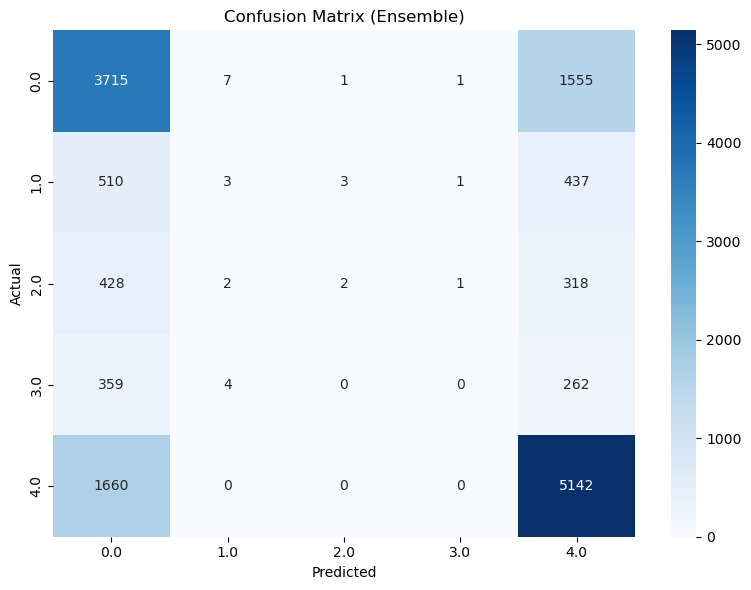


Classification Report (Ensemble):
              precision    recall  f1-score       support
0.0            0.556805  0.703732  0.621705   5279.000000
1.0            0.187500  0.003145  0.006186    954.000000
2.0            0.333333  0.002663  0.005284    751.000000
3.0            0.000000  0.000000  0.000000    625.000000
4.0            0.666580  0.755954  0.708460   6802.000000
accuracy       0.614947  0.614947  0.614947      0.614947
macro avg      0.348844  0.293099  0.268327  14411.000000
weighted avg   0.548377  0.614947  0.562820  14411.000000

Ensemble Evaluation Metrics:
F1 Score:   0.5628
Accuracy:   0.6149
Precision:  0.5484
Recall:     0.6149


In [ ]:
# Evaluate ensemble
y_true = merged_df['score']
y_pred = merged_df['ensemble_pred']
report = plot_confusion_matrix(y_true, y_pred)
f1 = evaluate_metrics(y_true, y_pred)

---
## **Understanding Our Model’s Performance**
---

We built a model to predict how well S&P 500 stocks perform, sorting them into five groups (0 = worst, 4 = best). Our model combines four strong models (H2O AutoML, LightGBM, XGBoost, GBTClassifier) to make better predictions. Below, we explain the results in a clear and simple way.

---

### **Classification Report: How Well Did We Predict Each Group?**
The classification report tells us how good our model is at predicting each group (0 to 4). It uses three key measures: **precision** (how many predictions were correct), **recall** (how many actual cases we caught), and **F1-score** (a balance of precision and recall).

- **Group 0 (Worst Performers, 5279 stocks)**:
  - **Precision (0.56)**: 56% of the time we said a stock was in group 0, we were right. Pretty good!
  - **Recall (0.70)**: We found 70% of the actual group 0 stocks. We caught most of them!
  - **F1-Score (0.62)**: This group was predicted well, as the score is high.

- **Group 1 (Slightly Bad Performers, 954 stocks)**:
  - **Precision (0.19)**: Only 19% of our group 1 predictions were correct. Not great.
  - **Recall (0.003)**: We missed almost all group 1 stocks (caught only 0.3%). Really bad!
  - **F1-Score (0.006)**: The super low score shows we struggled with this group.

- **Group 2 (Neutral Performers, 751 stocks)**:
  - **Precision (0.33)**: 33% of group 2 predictions were right. Not very reliable.
  - **Recall (0.003)**: We caught just 0.3% of group 2 stocks. Almost none!
  - **F1-Score (0.005)**: Another very low score, meaning we didn’t do well here.

- **Group 3 (Slightly Good Performers, 625 stocks)**:
  - **Precision (0.00)**: We got no group 3 predictions right. Complete failure.
  - **Recall (0.00)**: We missed every group 3 stock. Nothing caught!
  - **F1-Score (0.00)**: Zero score means we couldn’t predict this group at all.

- **Group 4 (Best Performers, 6802 stocks)**:
  - **Precision (0.67)**: 67% of group 4 predictions were correct. Solid performance!
  - **Recall (0.76)**: We found 76% of actual group 4 stocks. We caught most of them!
  - **F1-Score (0.71)**: High score shows we did well predicting the best stocks.

- **Overall Averages**:
  - **Macro Average (Precision: 0.35, Recall: 0.29, F1: 0.27)**: When we average all groups equally, the scores are low because we did poorly on groups 1, 2, and 3.
  - **Weighted Average (Precision: 0.55, Recall: 0.61, F1: 0.56)**: When we account for how many stocks are in each group, the scores look better because groups 0 and 4 (with more stocks) did well.

---

### **Evaluation Metrics: Big Picture Results**
These numbers sum up how the model did overall:
- **F1 Score (0.56)**: Our model is okay at balancing correct predictions and catching true cases, but it’s dragged down by groups 1, 2, and 3.
- **Accuracy (0.61)**: We got 61% of all predictions right. Decent, but not amazing, because we missed many stocks in smaller groups.
- **Precision (0.55)**: 55% of our predictions were correct overall. Okay, but weaker for smaller groups.
- **Recall (0.61)**: We caught 61% of all true cases. Good for big groups, bad for small ones.
---

### **What Does This Mean?**
- **We’re Great at Big Groups**: Our model does well at spotting the worst (group 0) and best (group 4) stocks, which have the most data (5279 and 6802 stocks). This is important because these groups are common and matter a lot for investors.
- **We Struggle with Small Groups**: Groups 1, 2, and 3 (954, 751, and 625 stocks) are much smaller, and our model barely predicts them correctly. This is because there’s not enough data for these groups, making it hard for the model to learn.
- **Class Imbalance Hurts Us**: The huge difference in group sizes (imbalance) makes our model focus on groups 0 and 4, ignoring the smaller ones. This skews our results.
----

### **Why It Matters**
- **Investors Need Reliable Predictions**: If we can’t predict groups 1, 2, and 3 well, investors might miss opportunities or risks in those stocks. We need to fix this to make our model more useful.
- **Ensemble Helped a Bit**: Combining four models made our predictions better than using one model alone, but it wasn’t enough to solve the problem with small groups.
---

### **What Can We Do Better?**
- **Balance the Data**: We could use tricks like oversampling (making more fake data for groups 1, 2, and 3) to help the model learn about these smaller groups.
- **Focus on Small Groups**: We could tweak the model to pay more attention to groups 1, 2, and 3 by giving them higher importance during training.
- **Get More Data**: If possible, more data for groups 1, 2, and 3 would help the model understand them better.

---